# Setup

- ADS: Carla garage (TP++)
- Repetitions: 1
- 132 sliced scenarios

# Loading data in one DF

In [61]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path

pd.set_option('display.max_rows', 30)

In [62]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    # df = df.rename(columns={"index": "route_index"})
    df = df.set_index(['fps', 'highquality', 'index'])
    return df

In [63]:
def make_df(path: str):
    with open(path, "r") as f:
        path = path.strip("data/.json")
        print(path)
        it = iter(path.split("_"))
        data = dict(zip(it, it))

        content = json.load(f)
        data['records'] = content['_checkpoint']['records']

        df = pd.DataFrame(data)
        return process_df(df)

In [64]:


dfs = []
path = "data/*.json"
for file_path in glob.glob(path):
    dfs.append(make_df(file_path))

df_combined = pd.concat(dfs)
# drop 30 fps
df_combined = df_combined.drop(labels=['30'], axis=0)
df_combined.info()

fps_20_highquality_True
fps_20_highquality_False
fps_10_highquality_False
fps_30_highquality_True
fps_18_highquality_True
fps_12_highquality_True
fps_14_highquality_True
fps_10_highquality_True
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 924 entries, ('20', 'True', 0) to ('10', 'True', 131)
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   route_id                           924 non-null    object 
 1   status                             924 non-null    object 
 2   infractions.collisions_layout      924 non-null    object 
 3   infractions.collisions_pedestrian  924 non-null    object 
 4   infractions.collisions_vehicle     924 non-null    object 
 5   infractions.outside_route_lanes    924 non-null    object 
 6   infractions.red_light              924 non-null    object 
 7   infractions.route_dev              924 non-null    object 
 8   infractions.route_timeou

/tmp/ipykernel_9441/2381262022.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_combined = df_combined.drop(labels=['30'], axis=0)


# Research questions


- RQ1: How does lowering the simulation's fidelity affect its execution time?
  - RQ1a: FPS impact on execution time
  - RQ1b: Rendering quality impact on execution time
- RQ2: How does lowering the simulation's fidelity affect evaluation results?
  - RQ2a: FPS impact on evaluation results
  - RQ2b: Rendering quality impact on evaluation results
- RQ3: How does lowering the simulation's fidelity affect using existing ADS testing techniques?


# Answering RQ1a & RQ2a

In [65]:
# take all rows where we were using high quality
df = df_combined.xs("True", level='highquality')
df = df.reset_index()

In [66]:
df.groupby('fps')["score_composed"].mean().sort_index(ascending=False)

fps
20    85.520782
18    86.529388
14    76.152762
12    60.303150
10    49.153971
Name: score_composed, dtype: float64

In [67]:
def plot(column: str, ax=None, col="b"):
    axes = df.groupby('fps')[column].mean().sort_index(
        ascending=False).plot(linestyle='dashed', marker='s', color=col,)

    return axes

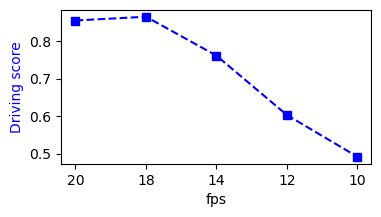

In [68]:
fig, axes = plt.subplots(squeeze=True)
fig.set_size_inches(4, 2)
axes = plot("driving_score", axes)
axes.set_ylabel(f"Driving score", color='b')


# axes = plot("duration_system", axes.twinx(), 'g')
# axes.set_ylabel(f"System time [s]", color='g')
# axes.set_ylim(100)

fig.savefig('plot.pdf', bbox_inches='tight')
# fig

# Prediction error

$\operatorname {MSE} ={\frac {1}{n}}\sum _{i=1}^{n}\left(Y_{i}-{\hat {Y_{i}}}\right)^{2}$

/tmp/ipykernel_9441/2506008785.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['square_error'] = (df['driving_score'] -


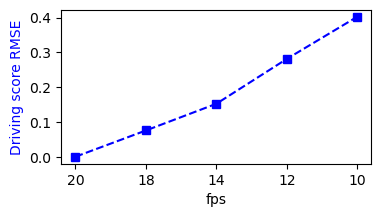

In [69]:
df = df_combined.xs("True", level='highquality')
oracle_df = df.xs(("20"),)

df['square_error'] = (df['driving_score'] -
                      oracle_df['driving_score']).pow(2).pow(1./2)

fig, axes = plt.subplots(squeeze=True)
fig.set_size_inches(4, 2)

axes = plot("square_error", ax=axes)
axes.set_ylabel(f"Driving score RMSE", color='b')


# axes = plot("duration_system", axes.twinx(), 'g')
# axes.set_ylabel(f"Execution time [s]", color='g')
# axes.set_ylim(100)

fig.savefig('plot.pdf', bbox_inches='tight')
# fig

# Answering RQ1b & RQ2b

Currently

- 20 EPIC, 20 LOW
- 10 EPIC, 10 LOW

In [70]:
from itertools import product

hq_vals = [True, False]
fps_vals = [20, 10]
df = pd.concat(
    [
        df_combined.xs((str(fps), str(hq)), drop_level=False)
        for (fps, hq) in product(fps_vals, hq_vals)
    ])

# df

/tmp/ipykernel_9441/2828509555.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_combined.xs((str(fps), str(hq)), drop_level=False)


In [71]:
oracle_df = df.xs(("20", "True"),)

df['square_error'] = (df['driving_score'] -
                      oracle_df['driving_score']).pow(2).pow(1./2)


# df = df.reset_index()

/tmp/ipykernel_9441/742066664.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  oracle_df = df.xs(("20", "True"),)


In [72]:
df.xs(("20")).groupby('highquality')["square_error"].mean().sort_index(
    ascending=False)

highquality
True     0.000000
False    0.153687
Name: square_error, dtype: float64

[Text(False, 0, 'Epic'), Text(True, 0, 'Low')]

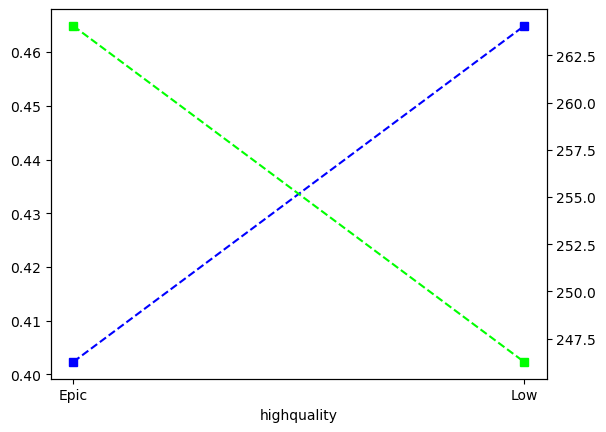

In [73]:
fig, axes = plt.subplots()

# # DRIVING SCORE 20FPS and 10FPS
# axes = df.xs(("20")).groupby('highquality')["square_error"].mean().sort_index(
#     ascending=False).plot(linestyle='dashed', marker='s', ax=axes, color="navy")

axes = df.xs(("10")).groupby('highquality')["square_error"].mean().sort_index(
    ascending=False).plot(linestyle='dashed', marker='s', ax=axes, color="blue")

# axes.set_ylim(0, 1)

axes = axes.twinx()
# DRIVING SCORE 20FPS and 10FPS
# axes = df.xs(("20")).groupby('highquality')["duration_system"].mean().sort_index(
#     ascending=False).plot(linestyle='dashed', marker='s', ax=axes, color="green")

axes = df.xs(("10")).groupby('highquality')["duration_system"].mean().sort_index(
    ascending=False).plot(linestyle='dashed', marker='s', ax=axes, color="lime")


axes.set_xticks([False, True])
axes.set_xticklabels(["Epic", "Low"])

## Rendering quality t-tests

In [74]:
def ttest(fps, column_name):

    epic = df.xs((fps, "True"), drop_level=False)[column_name]

    low = df.xs((fps, "False"), drop_level=False)[column_name]

    confidence_level = 0.95
    max_error = 1 - confidence_level

    t_statistic, p_value = scipy.stats.ttest_ind(
        epic, low)

    print(f"\nFor {column_name = }")
    print(f"\tP-value: {p_value:.5f}")

    if p_value < max_error:
        print(f"\tThe difference for {fps = } is statistically significant.")
    else:
        print(
            f"\tThe difference for {fps = } is not statistically significant.")

In [75]:
ttest("20", "driving_score")

ttest("10", "driving_score")


For column_name = 'driving_score'
	P-value: 0.02456
	The difference for fps = '20' is statistically significant.

For column_name = 'driving_score'
	P-value: 0.06476
	The difference for fps = '10' is not statistically significant.


/tmp/ipykernel_9441/2184194544.py:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  epic = df.xs((fps, "True"), drop_level=False)[column_name]
/tmp/ipykernel_9441/2184194544.py:5: PerformanceWarning: indexing past lexsort depth may impact performance.
  low = df.xs((fps, "False"), drop_level=False)[column_name]
